# 03_pyFAI Thresholding

SSA adapted and developed from original code provided by Beth Galtry

converts 2D detector images into 1D diffraction patterns (I vs 2theta)


applies 'thresholding' to seperate signal to noise 

output: individual integrated 1D patterns for each collection in a run :) 

In [2]:
# beth 
#import relevant modules 
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import matplotlib as mpl
import pandas as pd        
import math

import sys
!{sys.executable} -m pip install pyFAI
import pyFAI
from pyFAI.gui import jupyter

!{sys.executable} -m pip install pybaselines
from pybaselines import Baseline
from pybaselines.utils import gaussian

pi = math.pi

### Define the diffraction frame to be read in 

In [1813]:
#scarlett adaptations 
# data file from I11 in form i11-1-61284.nxs, adjust depending on data name and format


from pathlib import Path

data_file_no = "108114"
data_dir = Path("D:/I11 Beamtime July/RAW_2D/Run_8_X2_0.5VF/")  #this is the generic path "C:/path/to/your/data/file/"

file_path = data_dir / f"i11-1-{data_file_no}.nxs"

if file_path.exists():
    print(f"File loaded successfully: {file_path}")
else:
    print(f"Error: File not found at {file_path}")


File loaded successfully: D:\I11 Beamtime July\RAW_2D\Run_8_X2_0.5VF\i11-1-108114.nxs


In [1814]:
#beth 
# creation of folder to store processed information
#processing_folder = "processed_patterns/individual_frames/"
#processing_path = os.path.join(data_dir,processing_folder)


#if not os.path.exists(processing_path):
    #os.makedirs(processing_path)

In [1815]:
#beth 
with h5py.File(file_path, 'r') as dat:
    
    #load in as (1,2881, 2880) shape array
    myData = np.array(dat["/entry1/pixium_hdf/data"][()][:]) 
    
    #extract only (2881,2880)
    diff_frame = myData.reshape(myData.shape[1:])
    
total_intensity = np.sum(diff_frame)

diff_frame

array([[   0,   73,    6, ...,    0,    0,    0],
       [   0,    4,   12, ...,    6,    7,    4],
       [1292,    4,    3, ...,    2,    8,    9],
       ...,
       [   0,   15,    7, ...,    0,    4,    4],
       [   0,   81,    7, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=uint32)

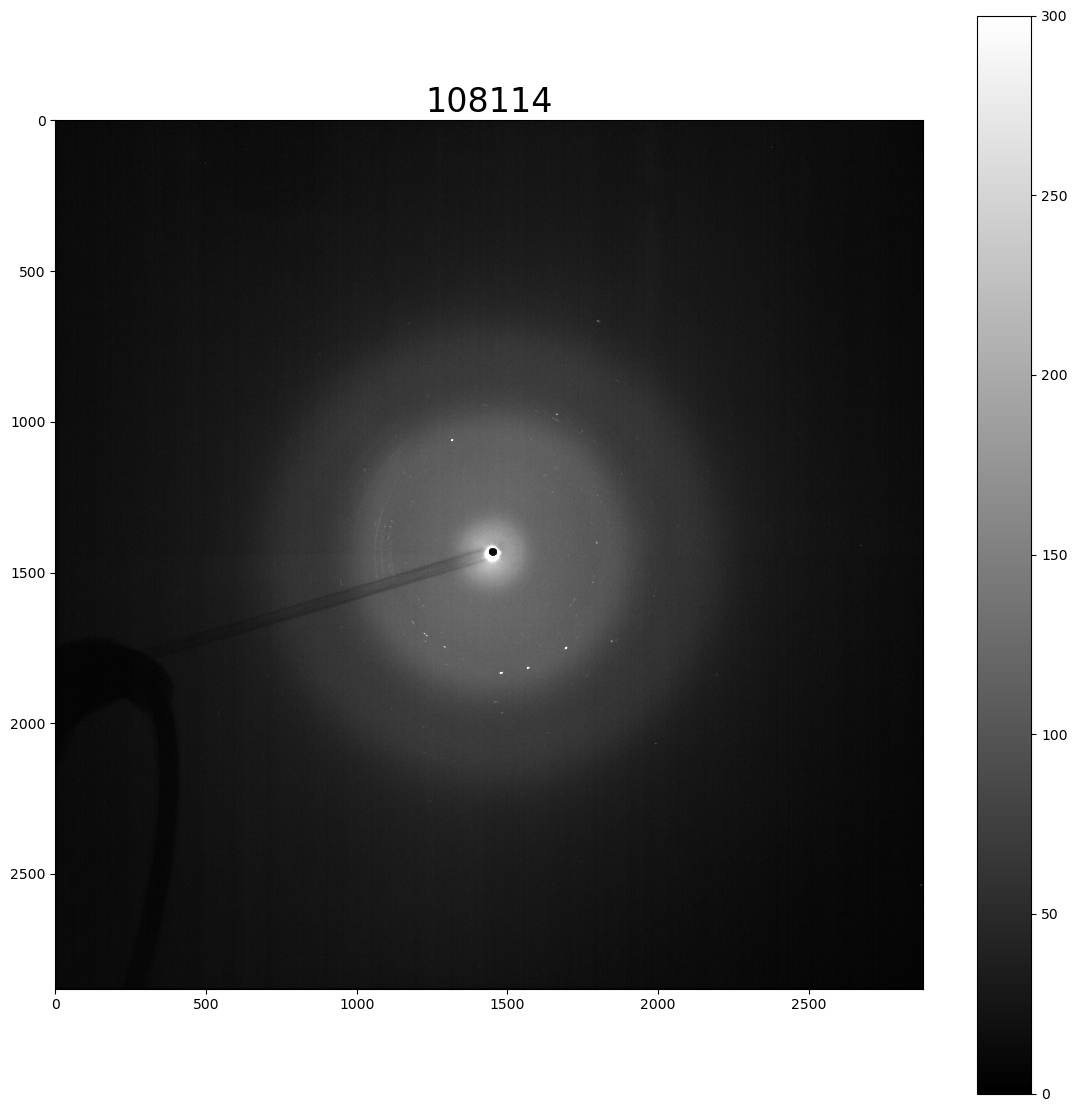

In [1816]:
#beth 
# visualise chosen diffraction frame

plt.rcParams["figure.figsize"]=14,14
plt.title(data_file_no, fontsize=24)
plt.imshow(diff_frame, cmap='gray', vmin=0, vmax=300)
plt.colorbar()
plt.show()

In [1817]:
#beth 
# specify background directory location from diffraction_sorting.py step for collection set
# also need to be .nxs files

background_dir = "D:/I11 Beamtime July/RAW_2D/Run_8_X2_0.5VF/Potential backgrounds" #generic backgrounds "C:/path/to/your/background/frames/"
count = 0
bg_file_nxs = []

# Count the number of .nxs files in directory
for files in os.listdir(background_dir):
    filename = os.fsdecode(files)
    if filename.endswith(".nxs"):
        bg_file_nxs.append(filename)
        count += 1
print('File count:', count)
print(bg_file_nxs)

File count: 18
['i11-1-108048.nxs', 'i11-1-108051.nxs', 'i11-1-108052.nxs', 'i11-1-108055.nxs', 'i11-1-108059.nxs', 'i11-1-108061.nxs', 'i11-1-108064.nxs', 'i11-1-108066.nxs', 'i11-1-108069.nxs', 'i11-1-108075.nxs', 'i11-1-108079.nxs', 'i11-1-108081.nxs', 'i11-1-108084.nxs', 'i11-1-108086.nxs', 'i11-1-108095.nxs', 'i11-1-108098.nxs', 'i11-1-108100.nxs', 'i11-1-108109.nxs']


In [1818]:
#scarlett adaptations 
# read in background frames and calculate total counts


background_dir = "D:/I11 Beamtime July/RAW_2D/Run_8_X2_0.5VF/Potential backgrounds"
bg_file_nxs = [f for f in os.listdir(background_dir) if f.endswith(".nxs")]
count = len(bg_file_nxs)

# hard-coded detector size
rows, cols = 2881, 2880

bg_frame_sized = np.zeros((count, rows, cols))
basic_bg_sub   = np.zeros((count, rows, cols))
total_intensity = np.zeros(count)

for a in range(count):
    with h5py.File(os.path.join(background_dir, bg_file_nxs[a]), 'r') as dat:
        background_frame = np.array(dat["/entry1/pixium_hdf/data"][()])
        bg_frame_sized[a] = background_frame.reshape(rows, cols)
        basic_bg_sub[a] = np.subtract(diff_frame, bg_frame_sized[a])
        basic_bg_sub[a][basic_bg_sub[a] < 0] = 0
        total_intensity[a] = np.sum(basic_bg_sub[a])


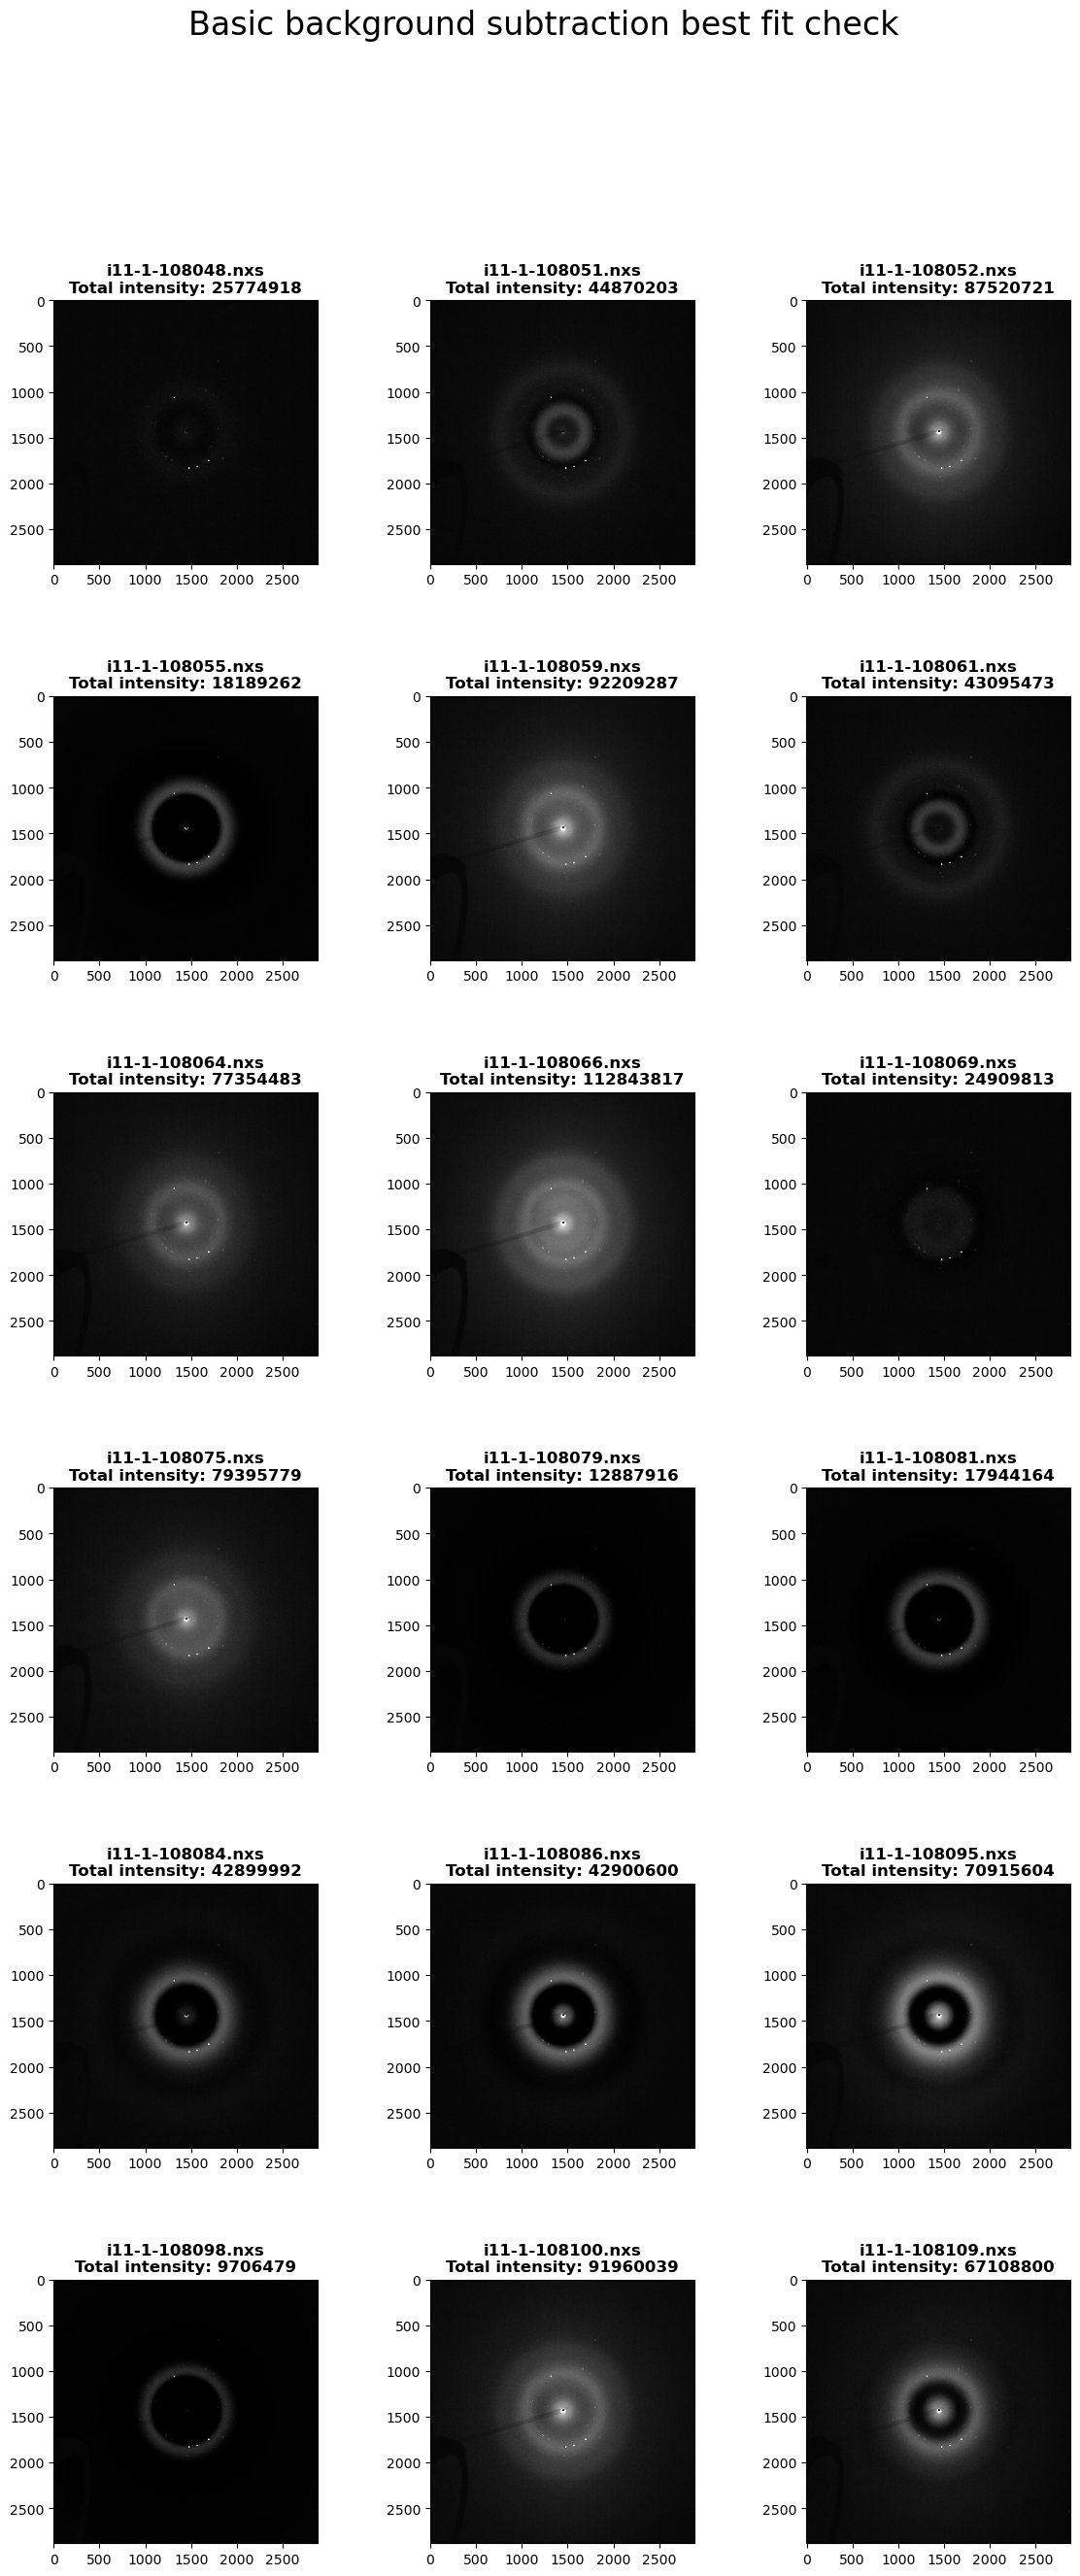

In [1819]:
# scarlett adaptations 
# visualisation of background best fit checks. 

import math

cols = 3
rows = math.ceil(count / cols)

fig, axs = plt.subplots(rows, cols, figsize=(15, rows*5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=.5, wspace=.001)
axs = axs.ravel()

for i in range(count):
    fig.suptitle('Basic background subtraction best fit check', fontsize=24)
    axs[i].imshow(basic_bg_sub[i], cmap='gray', vmin=0, vmax=100)
    axs[i].set_title(f"{bg_file_nxs[i]}\nTotal intensity: {round(total_intensity[i])}",
                     fontweight='bold')

# hide any unused subplots if rows*cols > count
for j in range(count, len(axs)):
    fig.delaxes(axs[j])


In [1677]:
#beth code 
# autoselection of best-fit background

#chosen_bg_name = bg_file_nxs[np.argmin(total_intensity)] 

#chosen_bg = bg_frame_sized[np.argmin(total_intensity)]

#print('Chosen background: ' + str(chosen_bg_name) + '\nTotal intensity: ' + str(total_intensity[np.argmin(total_intensity)]))
#print('chosen background:' + chosen_bg)

In [1820]:
#Scarlett adaptation for manual overwrite of background selection if wants 
# automatic choice
auto_idx = np.argmin(total_intensity)

# --- manual overwrite (pick index manually) ---
manual_idx = 0 # <- change this to whichever background you want - write None for automatic indexing - indexing starts at 0!!!

# use manual if set, otherwise fallback to auto
idx = manual_idx if manual_idx is not None else auto_idx

chosen_bg_name = bg_file_nxs[idx]
chosen_bg = bg_frame_sized[idx]

print('Chosen background: ' + str(chosen_bg_name) + 
      '\nTotal intensity: ' + str(total_intensity[idx]))


Chosen background: i11-1-108048.nxs
Total intensity: 25774918.0



this should have suggested the best background file for that collection - check against visualisation.

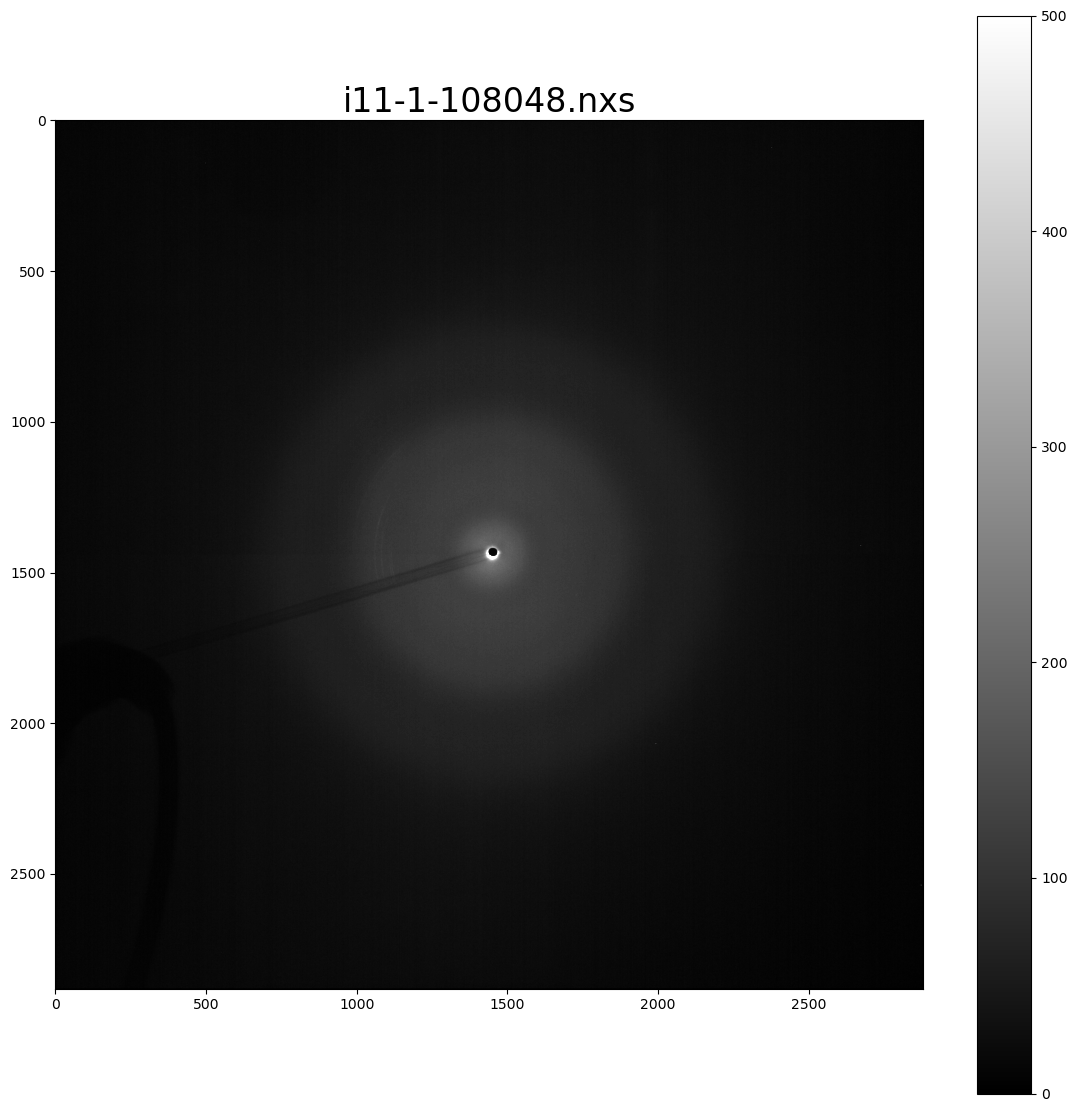

In [1821]:
#beth
# visualisation of chosen background frame

plt.rcParams["figure.figsize"]=14,14
plt.title(chosen_bg_name, fontsize=24)
plt.imshow(chosen_bg, cmap='gray', vmin=0, vmax=500)
plt.colorbar()
plt.show()

In [1822]:
#beth
# background subtraction of background frame from diffraction frame

pattern_process = diff_frame - chosen_bg

basic_pattern_name = data_file_no + "_bg_" + chosen_bg_name[6:-4]
basic_pattern_name

'108114_bg_108048'

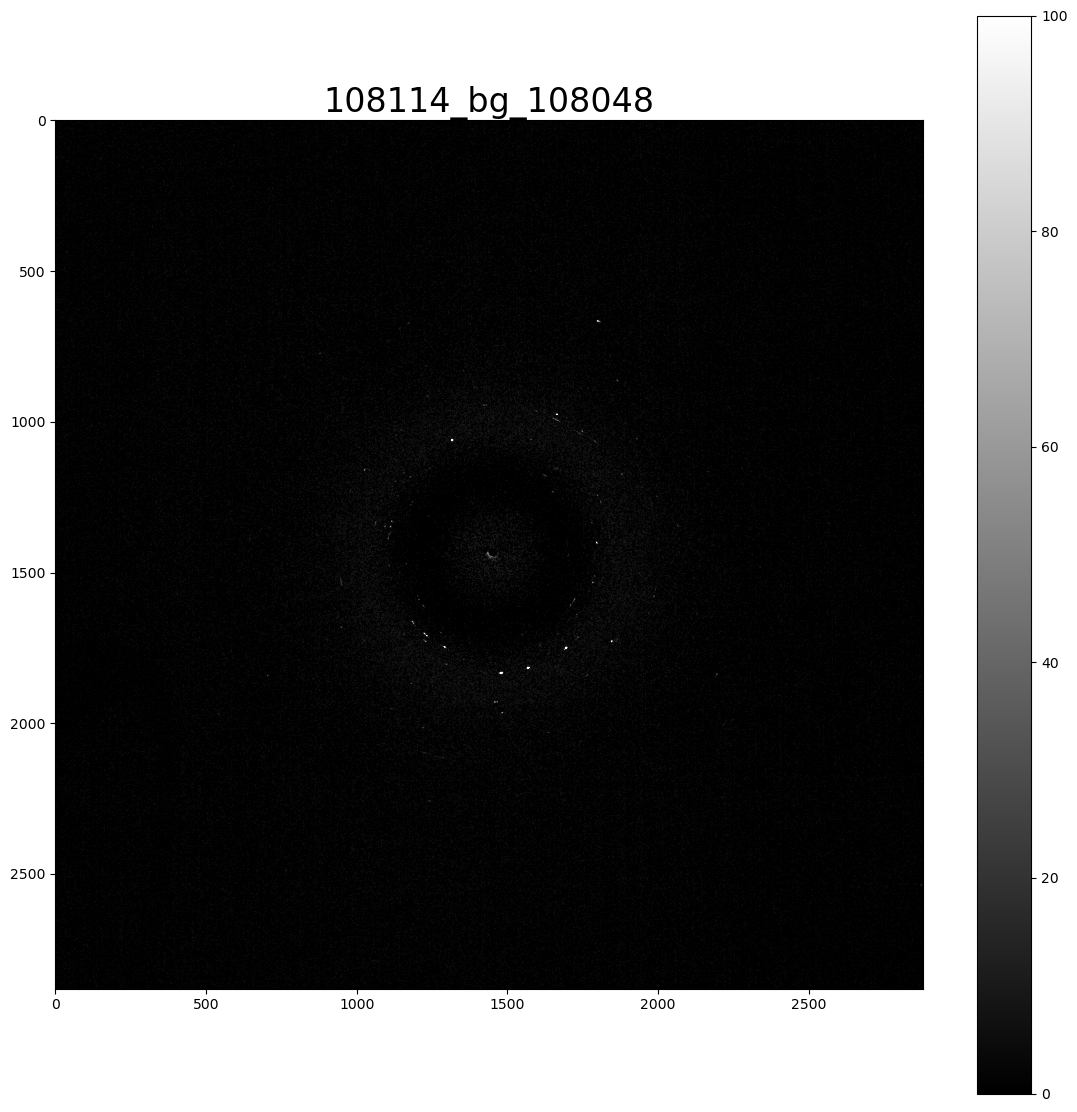

In [1823]:
#beth 
# visualisation of basic background subtraction



plt.rcParams["figure.figsize"]=14,14
plt.title(basic_pattern_name, fontsize=24)
plt.imshow(pattern_process, cmap='gray', vmin=0, vmax=100)
plt.colorbar()
#plt.savefig(processing_path + basic_pattern_name +".png")
plt.show()

In [1824]:
# Scarlett
# save the initial Background Subtraction!!

# state base directory 
base_dir = r"D:/I11 Beamtime July/RAW_2D/Run_8_X2_0.5VF/"

# save new directory inside of it :) 
save_dir = os.path.join(base_dir, "basic_bg_subtraction")
os.makedirs(save_dir, exist_ok=True)

# save data array 
npy_path = os.path.join(save_dir, basic_pattern_name + "_process.npy")
np.save(npy_path, pattern_process)


# re-create the figure (same as before)
plt.rcParams["figure.figsize"]=14,14
plt.title(basic_pattern_name, fontsize=24)
plt.imshow(pattern_process, cmap='gray', vmin=0, vmax=100)
plt.colorbar()

# save figure
png_path = os.path.join(save_dir, basic_pattern_name + "_process.png")
plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.close()  # close so it doesn’t pop up again

print(f"Saved data to {npy_path}")
print(f"Saved figure to {png_path}")


Saved data to D:/I11 Beamtime July/RAW_2D/Run_8_X2_0.5VF/basic_bg_subtraction\108114_bg_108048_process.npy
Saved figure to D:/I11 Beamtime July/RAW_2D/Run_8_X2_0.5VF/basic_bg_subtraction\108114_bg_108048_process.png


# Thresholding 

now we have a better 2D pattern, try seperate a bit of the signal from noise in the diffraction pattern 

In [1840]:
#beth 
# thresholding to remove remaining noise - change threshold_value

pattern_processing = diff_frame - chosen_bg

threshold_value = 30 #120 was the value when Beth handed code over just fyi :) - higher the value - more 'masking'out of noise (been finding 70 has been working generaly) 

pattern_processing[pattern_processing < threshold_value] = 0

thresholded_frame = pattern_processing

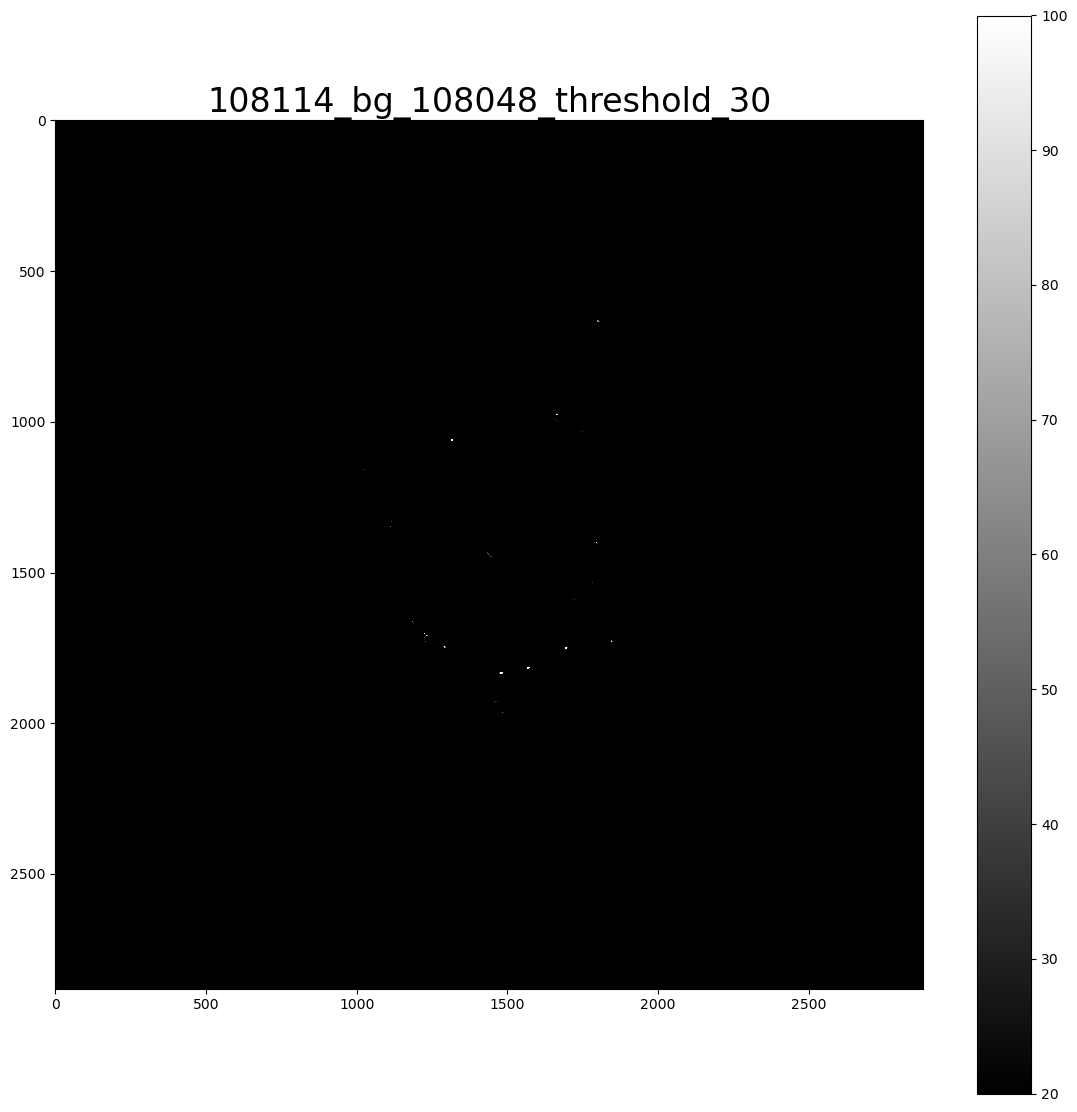

In [1841]:
#beth 
# visualise thresholding, change threshold value if noise remains

threshold_pattern_name = data_file_no + "_bg_" + chosen_bg_name[6:-4] + "_threshold_" + str(threshold_value)

plt.rcParams["figure.figsize"]=14,14
plt.title(threshold_pattern_name, fontsize=24)
plt.imshow(thresholded_frame, cmap='gray', vmin=20, vmax=100)
plt.colorbar()
#plt.savefig(processing_path + threshold_pattern_name + ".png")
plt.show()

# Load Calibration File 


pyFai: https://pyfai.readthedocs.io/en/v2023.1/

calibration complete via pyFAI-calib2 tool 

In [39]:
#beth 
# load the calibration .poni file 
calibration = pyFAI.load('D:/I11 Beamtime July/calib_kap.poni')  #('C:/poni/file/location/calibration.poni')
calibration

Detector Detector	 PixelSize= 148µm, 148µm	 BottomRight (3)
Wavelength= 4.948700e-11 m
SampleDetDist= 4.361822e-01 m	PONI= 2.130993e-01, 2.147126e-01 m	rot1=0.000684  rot2=-0.001168  rot3=0.000000 rad
DirectBeamDist= 436.183 mm	Center: x=1448.746, y=1436.418 pix	Tilt= 0.078° tiltPlanRotation= -120.335° 𝛌= 0.495Å

In [40]:
#beth 
#load mask for detector frame 
oneD_mask = np.load("D:/I11 Beamtime July/calib_kap_mask.npy") #("C:/mask/file/location/mask.npy")


# Integration using pyFAI module 

### Fast Azimuthal Integration using Python - pyFAI: https://pyfai.readthedocs.io/en/v2023.1/

core idea is to redistribute the signal acquired with the experimental geometry into a geometry suitable for further analysis - e.g. Reitveld refinement 

In [1842]:
#beth 
#firstly integrate mask previous spectra that has just been thresholded 
mask = np.load("D:/I11 Beamtime July/calib_kap_mask.npy")

# this produces 1D array data Vs 2theta ready for plotting 
oneD_integrated_plot_thresholded = calibration.integrate1d(
    thresholded_frame,
    1000,
    unit=pyFAI.units.TTH_DEG,
    radial_range=[0,30],
    mask=mask
)


Text(0, 0.5, 'Intensity')

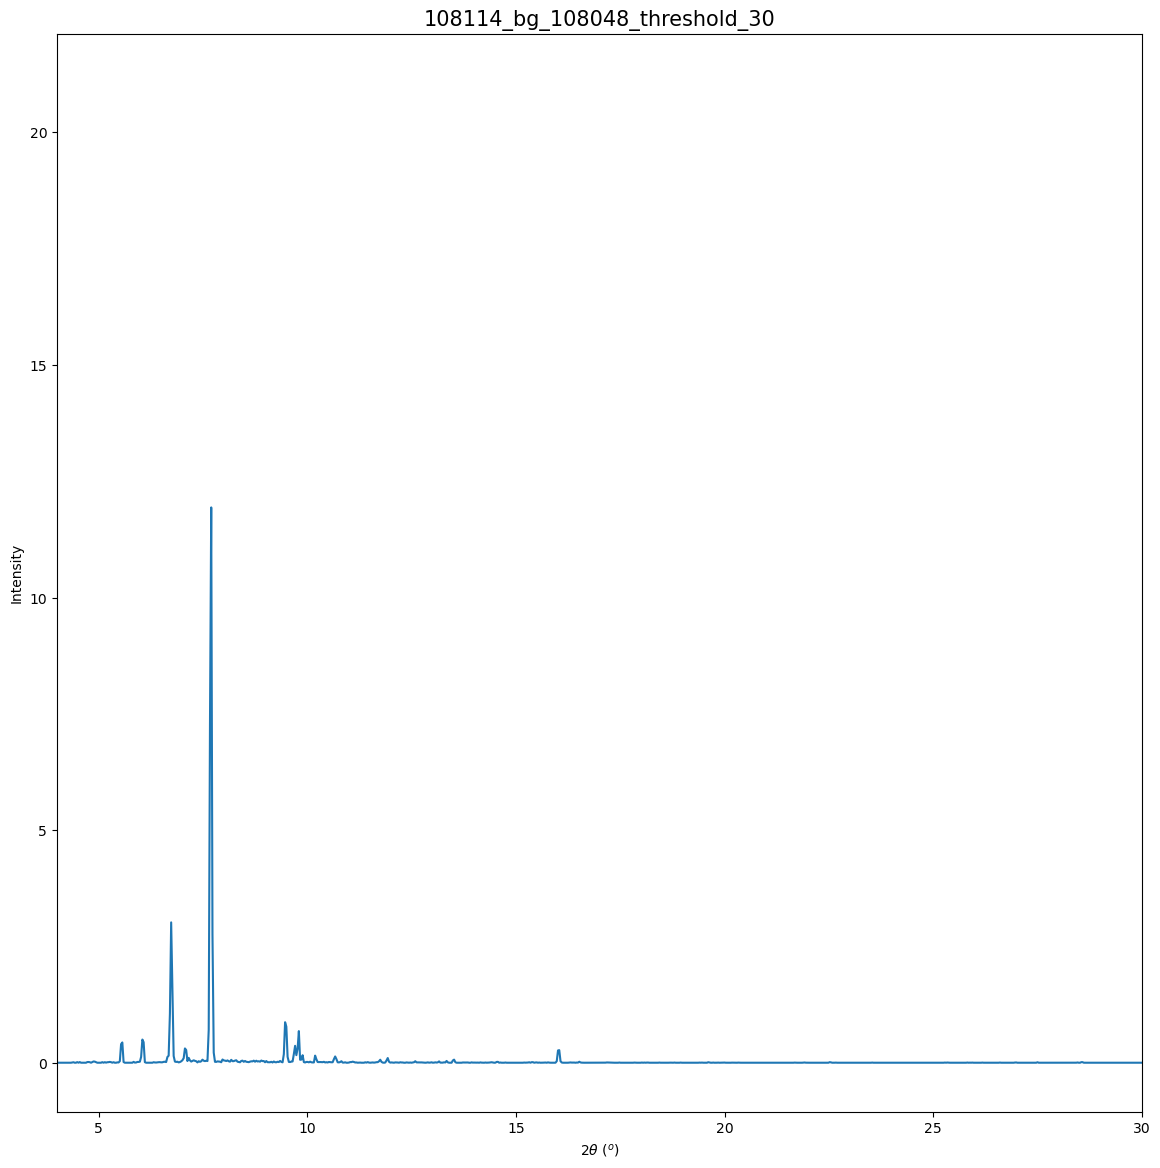

In [1843]:
# Re-threshold if noise remains
# plot 
jupyter.plot1d(oneD_integrated_plot_thresholded)
plt.title(threshold_pattern_name, fontsize=15)
plt.xlabel('$2\\theta$ ($^{o}$)')
plt.xlim(4, 30)
#plt.ylim(-0.1,3)
plt.ylabel('Intensity')
#plt.savefig(processing_path + threshold_pattern_name +"_1D_plot_zoom")


In [1844]:
# Scarlett - Save 1D thresholded plot, XY, and XYE data together

# Base directory where everything lives
base_dir = r"D:/I11 Beamtime July/RAW_2D/Run_8_X2_0.5VF/" #<-----------------CHANGE THIS 
# Create new directory for outputs
save_dir = os.path.join(base_dir, "03_pyFAI_Thresh_1D_Plot")
os.makedirs(save_dir, exist_ok=True)

#1D plot save as png 
plt.figure(figsize=(10,6))
plt.plot(oneD_integrated_plot_thresholded.radial, oneD_integrated_plot_thresholded.intensity, color='black')
plt.title(threshold_pattern_name, fontsize=15)
plt.xlabel('$2\\theta$ ($^{o}$)')
plt.ylabel('Intensity')
plt.xlim(4, 30)

png_path = os.path.join(save_dir, threshold_pattern_name + "_1D_plot.png")
plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.close()

# Extract arrays
x_vals = oneD_integrated_plot_thresholded.radial   # 2θ
y_vals = oneD_integrated_plot_thresholded.intensity  # Intensity
errors = np.sqrt(np.maximum(y_vals, 1))  # simple Poisson estimate

#1D plt save as .xy
xy_path = os.path.join(save_dir, threshold_pattern_name + ".xy")
np.savetxt(xy_path, np.c_[x_vals, y_vals],
           fmt="%.6f", header="2theta(deg) Intensity", comments='')

#1D plot save as .xye
xye_path = os.path.join(save_dir, threshold_pattern_name + ".xye")
np.savetxt(xye_path, np.c_[x_vals, y_vals, errors],
           fmt="%.6f", header="2theta(deg) Intensity Error", comments='')

print(f"Saved plot to: {png_path}")
print(f"Saved XY data to: {xy_path}")
print(f"Saved XYE data to: {xye_path}")


Saved plot to: D:/I11 Beamtime July/RAW_2D/Run_8_X2_0.5VF/03_pyFAI_Thresh_1D_Plot\108114_bg_108048_threshold_30_1D_plot.png
Saved XY data to: D:/I11 Beamtime July/RAW_2D/Run_8_X2_0.5VF/03_pyFAI_Thresh_1D_Plot\108114_bg_108048_threshold_30.xy
Saved XYE data to: D:/I11 Beamtime July/RAW_2D/Run_8_X2_0.5VF/03_pyFAI_Thresh_1D_Plot\108114_bg_108048_threshold_30.xye
